In [20]:
import cv2
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
from glob import glob

from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, sampler, random_split, Dataset
import torch
import timm
import random

import pandas as pd

In [56]:
df = pd.read_csv('./fold_result.csv')
df['model'] = df['runname'].str.split('_').str[:-2].str.join('-')
df['fold'] = df['runname'].str.split('_').str[-1]
df.drop(columns="runname",inplace=True)
df_val = df[df['Eval on']=='Validation']
df_val.drop(columns='Eval on',inplace=True)
df_val.set_index(['model','fold'])

/tmp/ipykernel_2729800/1305125724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns='Eval on',inplace=True)


Accuracy
model           fold           
regnety-008     5     98.235887
                4     98.263889
                3     98.784722
                2     98.258289
                1     98.090278
regnety-006     5     97.911067
                4     98.258289
                3     98.784722
                2     98.431900
                1     96.846998
regnety-004     5     96.510977
                4     97.905466
                3     98.426299
                2     98.263889
                1     97.205421
resnext50-32x4d 5     98.090278
                4     97.569444
                3     98.252688
                2     98.611111
                1     97.563844
efficientnet-b2 5     96.510977
                4     97.043011
                3     97.037410
                2     97.048611
                1     97.216622
efficientnet-b1 5     95.995744
                4     96.522178
                3     97.731855
                2     96.858199
                1     96.690188
efficientnet-b0 5     97.390233
                4     96.326165
                3     98.784722
                2     98.067876
                1     97.216622
seresnet50      5     97.569444
                4     96.673387
                3     98.090278
                2     98.073477
                1     97.222222
resnet50        5     96.863799
                4     98.431900
                3     98.952733
                2     98.605511
                1     96.875000
resnet34        5     97.899866
                4     97.390233
                3     98.784722
                2     97.731855
                1     97.905466

In [44]:
df_val.groupby(by='model').mean().sort_values(by='Accuracy', ascending=False)

,Accuracy
model,
regnety-008,98.326613
regnety-006,98.046595
resnext50-32x4d,98.017473
resnet50,97.945789
resnet34,97.942428
regnety-004,97.662410
efficientnet-b0,97.557124
seresnet50,97.525762
efficientnet-b2,96.971326


In [2]:
DEVICE = torch.device("cpu")
torch.manual_seed(276)
SHAPE = (256,256,1)
IN_CHANNELS = 1
NUM_CLASSES = 4
BATCH_SIZE = 16
WEIGHT_PATH = '/data/users/6370327221/project/brain-mri-cls/weight/'
CLASS_MAP = {'0':'no_tumor', '1':'glioma', '2':'meningioma', '3':'pituatary'}

In [3]:
def getImageFromDataset(testDataset, idx):
    sampleImage, sampleLabel, path = testDataset.__getitem__(idx)[0], testDataset.__getitem__(idx)[1].numpy(), str(testDataset.__getitem__(idx)[2])
    sampleLabel = int(sampleLabel)
    sampleImage = ((sampleImage.permute(1,2,0).numpy()))
    sampleClassName = sampleLabel
    return sampleImage, sampleClassName, path

In [4]:
def test_model(dataloader, model):
    model.eval()
    correct_images = 0
    total_images = 0
    all_labels = []
    all_conf = []
    all_predicted = []
    test_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    with torch.no_grad():
        for batch_idx, batch_data in test_bar:
            images, labels, im_path = batch_data
            images, labels, im_path = images.to(DEVICE), labels.to(DEVICE), im_path
            outputs = model(images)
            scores = torch.nn.functional.softmax(outputs, dim=1)
            conf = torch.max(scores,1).values
            _, predicted = torch.max(outputs, 1)
            correct_images += (predicted == labels).sum().item()
            total_images += labels.size(0)
            accum_acc = round((correct_images/total_images)*100,4)
            test_bar.set_description("Testing accuracy: {}".format(accum_acc))
            all_labels.append(labels)
            all_predicted.append(predicted)
            all_conf.append(conf)
    
    all_conf = torch.cat(all_conf).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_predicted = torch.cat(all_predicted).cpu().numpy()
    return correct_images, total_images, all_labels, all_predicted, all_conf

In [5]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
def showRandomSamples(labels, predicted, conf,dataset, sampleNum=5):
    incorrect_im_path = []
    
    equals = labels == predicted 
    correctIdx = np.where(equals == 1)[0].tolist()
    
    incorrectIdx = np.where(equals == 0)[0].tolist()

    randomCorrectIdx = random.sample(correctIdx, sampleNum)
    randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

    _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

    for imageIdx in range(len(randomCorrectIdx)):
        image, className, path = getImageFromDataset(dataset, randomCorrectIdx[imageIdx])
        sample_conf = conf[randomCorrectIdx[imageIdx]]
        figure[0,imageIdx].imshow(image,cmap='gray')
        className = map_label_name(className)
        figure[0,imageIdx].title.set_text(f'[CORRECT] {str(className)} confidence : {str(sample_conf)}')
  
    for imageIdx in range(len(randomIncorrectIdx)):
        image, className, path = getImageFromDataset(dataset, randomIncorrectIdx[imageIdx])
        incorrect_im_path.append(path)
        figure[1,imageIdx].imshow(image,cmap='gray')
        predictedClassName = predicted[randomIncorrectIdx[imageIdx]]
        predictedClassName = int(predictedClassName)
        sample_conf = conf[randomIncorrectIdx[imageIdx]]
        className = map_label_name(className)
        predictedClassName = map_label_name(predictedClassName)
        figure[1,imageIdx].title.set_text(f'Actual: {str(className)} Predicted: {str(predictedClassName)} Conf : {str(sample_conf)}')
    plt.show()
    return incorrect_im_path

In [7]:
def map_label_name(cat):
    for k,v in CLASS_MAP.items():
            if k == str(cat):
                label = v
    return label

In [8]:
def create_model(backbone, is_feat_extract=False):
    model = timm.create_model(backbone, pretrained=True, 
                                         in_chans=IN_CHANNELS, num_classes=NUM_CLASSES)
    if is_feat_extract:
        model = unfreeze_only_fc(model)
        
    return model

In [9]:
def load_weight(model, backbone, fold):
    weight_path = os.path.join(WEIGHT_PATH, f"{backbone}_fold_{fold}.pth")
    weight = torch.load(weight_path, map_location=DEVICE)
    model.load_state_dict(weight)
    model.eval()
    return model

In [10]:
def plt_im(im_path):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image, cmap='gray')

In [11]:
class BrainDataset(Dataset):
    def __init__(
            self,
            root_dir = '/data/users/6370327221/dataset/MRI-Brain-tumor-cls/',
            is_train = True,
            transform = None
            ):
        if is_train:
            self.im_paths = sorted(glob(root_dir + 'Training/**' + '/*.jpg'))
        elif not is_train:
            self.im_paths = sorted(glob(root_dir + 'Testing/**' + '/*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, index):
        im_path = self.im_paths[index]
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image / 255.0

        label = im_path.split('/')[-2].split('_')[0]
        label = torch.tensor(int(label)).long()

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
            image = image.float()

        return image, label, im_path

In [12]:
transform = A.Compose(
            [
                A.Resize(height=256, width=256),
                ToTensorV2(),
            ]
        )

In [13]:
test_dataset = BrainDataset(is_train=False, transform=transform)

In [14]:
model = create_model('regnety_008')
model = load_weight(model, 'regnety_008', 3)

  0%|          | 0/25 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       105
           1       0.97      0.37      0.54       100
           2       0.70      0.98      0.82       115
           3       0.95      0.84      0.89        74

    accuracy                           0.80       394
   macro avg       0.86      0.80      0.79       394
weighted avg       0.85      0.80      0.78       394



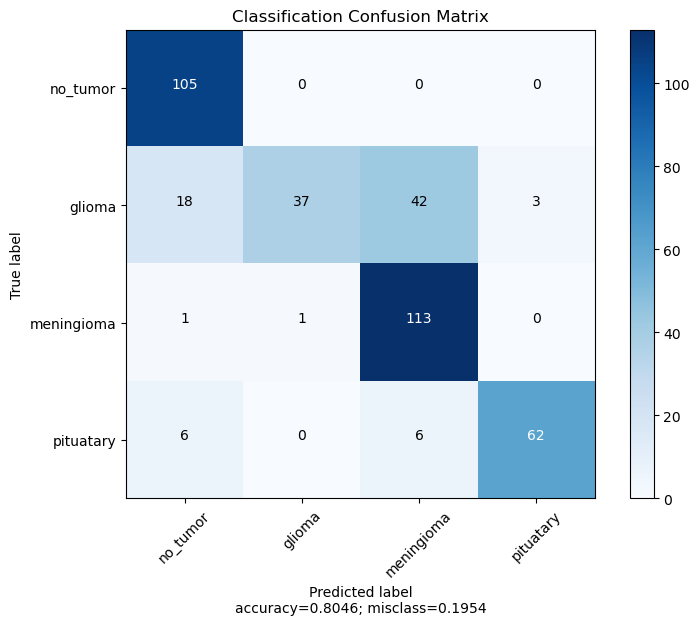

In [15]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False, num_workers=8)
correctImages, totalImages, testLabels, testPredicted, testConf = test_model(test_loader, model)
print(classification_report(testLabels, testPredicted))
confusionMatrix = confusion_matrix(testLabels, testPredicted)
plot_confusion_matrix(cm           = confusionMatrix, 
                      normalize    = False,
                      target_names = ['no_tumor','glioma','meningioma','pituatary'],
                      title        = "Classification Confusion Matrix")

true_pos = confusionMatrix[1][1] 
precision = true_pos / (true_pos + confusionMatrix[0][1])
recall = true_pos / (true_pos +  confusionMatrix[1][0])

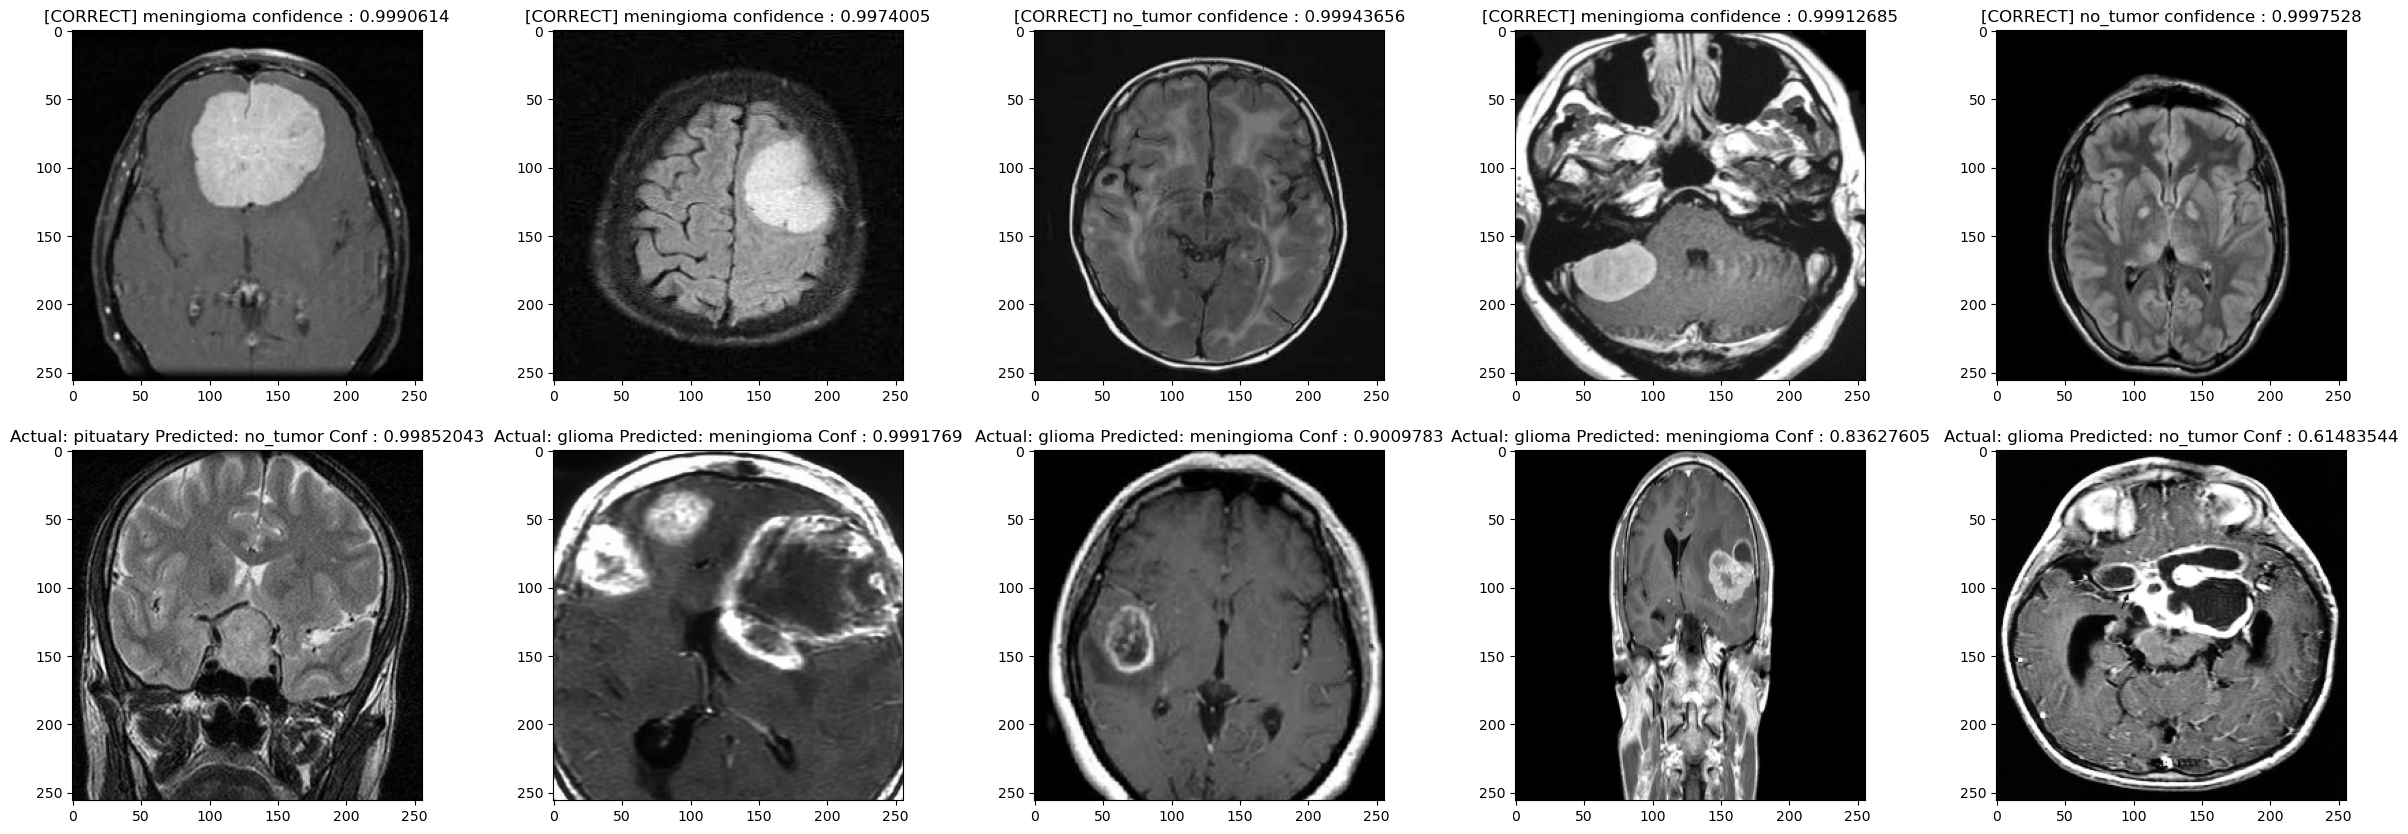

['/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/3_pituitary_tumor/image(45).jpg',
 '/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/1_glioma_tumor/image(5).jpg',
 '/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/1_glioma_tumor/image(93).jpg',
 '/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/1_glioma_tumor/image(97).jpg',
 '/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/1_glioma_tumor/image(22).jpg']

In [59]:
showRandomSamples(testLabels,testPredicted, testConf,test_dataset,sampleNum=5)

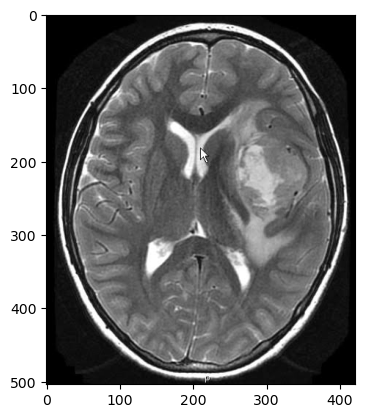

In [17]:
plt_im('/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/1_glioma_tumor/image(18).jpg')

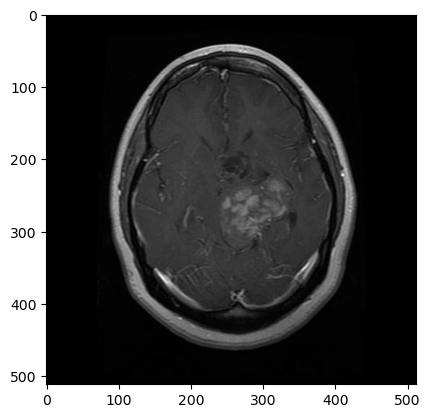

In [18]:
plt_im("/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Training/1_glioma_tumor/gg (1).jpg")

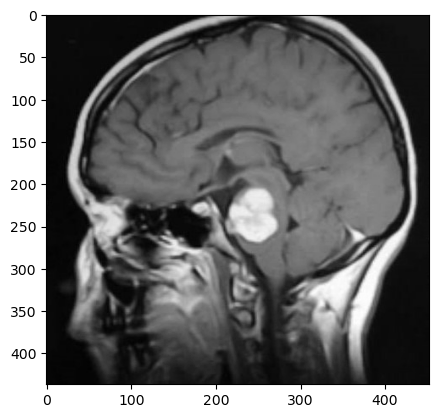

In [58]:
plt_im('/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Testing/1_glioma_tumor/image(17).jpg')

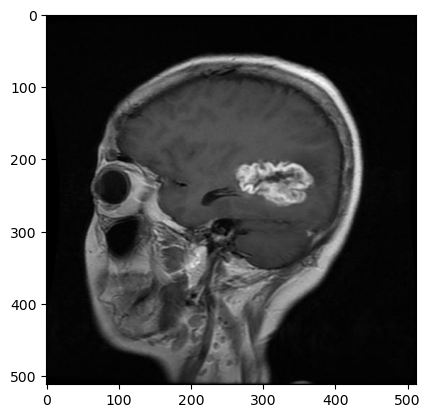

In [19]:
plt_im("/data/users/6370327221/dataset/MRI-Brain-tumor-cls/Training/1_glioma_tumor/gg (257).jpg")